### Chapter 6: Optimization
* How to find optimal elements from set of candidates
* Usually stated as finding min or max of function in given domain

In [169]:
%matplotlib inline
import matplotlib.pyplot as plt

In [170]:
import numpy as np
import sympy
from scipy import optimize     # nonlinear optimization
import cvxopt                  # convex optimization

[cvxopt library](http://stanford.edu/~boyd/cvxbook)

In [104]:
sympy.init_printing()

In [105]:
from __future__ import division

### Problem Classification
* Description:
    * minimization of f(x)
    * subject to m sets of equality constraints g(x)=0
    * subject to p sets of inequality constraints h(x)<=0
* General formulation == no good solver methods
* Some methods available for special cases
* *linear programming* problem: if f(x) & constraints are linear.
* *convex* nonlinear problems: only one global minimum
![pic](pics/convex-vs-nonconvex.png)

### Univariate optimization
* Bracketing & Newton's method can be applied
* *golden section search* algorithm - used in SciPy.optimize *golden()* method. Relatively safe, but slow convergence.
* SciPy.optimize *brent()* method == hybrid of golden & Newton's
* General-purpose: *minimize_scalar()* with method="golden","brent" or "bounded"

In [106]:
# example: area of cylinder with unit volume
# r = radius, h = height, f(r,h) = 2*pi*r^2 + 2*pi*r*h

#
# 2D optimization problem with an equality constraint
#

r, h = sympy.symbols("r, h")

In [107]:
Area   = 2*sympy.pi*r**2 + 2*sympy.pi*r*h
Volume =                     sympy.pi*r**2*h

In [108]:
h_r = sympy.solve(Volume - 1)[0]

In [109]:
Area_r = Area.subs(h_r)

In [110]:
rsol = sympy.solve(Area_r.diff(r))[0]
rsol

In [111]:
_.evalf()

In [112]:
# verify 2nd derivative is positive (rsol is a minimum)
Area_r.diff(r, 2).subs(r, rsol)

In [113]:
Area_r.subs(r, rsol)

In [114]:
_.evalf()

### Solve numerically

In [115]:
def f(r):
    return 2 * np.pi * r**2 + 2 / r

In [116]:
r_min = optimize.brent(f, brack=(0.1, 4))
r_min, f(r_min)

In [117]:
# radius that minimizes cylinder area ~ 0.54;
# corresponding min area ~ 5.54

optimize.minimize_scalar(f, bracket=(0.1, 5))

     fun: 5.5358104459320856
    nfev: 14
     nit: 13
 success: True
       x: 0.54192606489766715

In [118]:
r = np.linspace(0, 2, 100)

/home/bjpcjp/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


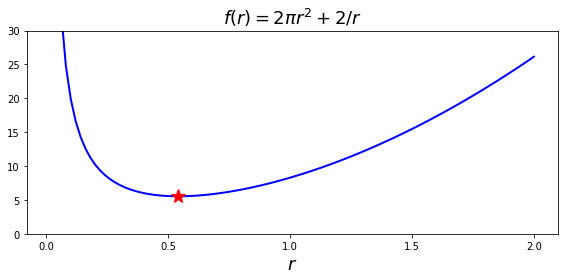

In [119]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(r, f(r), lw=2, color='b')
ax.plot(r_min, f(r_min), 'r*', markersize=15)
ax.set_title(r"$f(r) = 2\pi r^2+2/r$", fontsize=18)
ax.set_xlabel(r"$r$", fontsize=18)
ax.set_xticks([0, 0.5, 1, 1.5, 2])
ax.set_ylim(0, 30)

fig.tight_layout()
fig.savefig('ch6-univariate-optimization-example.pdf')

### Unconstrained Multivariate Optimization
* Much harder. Analytical & bracketing schemes not feasible.
* Instead try steepest descent method.
* Guaranteed to converge on **a** minimum, but show & prone to overshoot (ie, "zigzag").
* Newton's method can help. Can be viewed as local approximation of the function. Requires finding both the gradient & Hessian of the function.
* SciPy: Newton's implemented with *optimize.fmin_ncg(objective_func, starting_point, gradient_eval_func, hessian_eval_func (opt))*

In [120]:
x1, x2 = sympy.symbols("x_1, x_2")

In [121]:
# objective function
f_sym = (x1-1)**4 + 5 * (x2-1)**2 - 2*x1*x2

In [122]:
# gradient
fprime_sym = [f_sym.diff(x_) 
              for x_ in (x1, x2)]

sympy.Matrix(fprime_sym)

⎡                  3⎤
⎢-2⋅x₂ + 4⋅(x₁ - 1) ⎥
⎢                   ⎥
⎣-2⋅x₁ + 10⋅x₂ - 10 ⎦

In [123]:
# hessian
fhess_sym = [
    [f_sym.diff(x1_, x2_) for x1_ in (x1, x2)] 
    for x2_ in (x1, x2)]

sympy.Matrix(fhess_sym)

⎡           2    ⎤
⎢12⋅(x₁ - 1)   -2⎥
⎢                ⎥
⎣     -2       10⎦

In [124]:
# use symbolic expressions to create vectorized functions for them
f_lmbda      = sympy.lambdify((x1, x2), f_sym, 'numpy')
fprime_lmbda = sympy.lambdify((x1, x2), fprime_sym, 'numpy')
fhess_lmbda  = sympy.lambdify((x1, x2), fhess_sym, 'numpy')

In [125]:
# funcs returned by sympy.lambdify take one arg for each var
# SciPy optimization func expect a vectorized function.
# need a wrapper.

def func_XY_X_Y(f):
    """
    Wrapper for f(X) -> f(X[0], X[1])
    """
    return lambda X: np.array(f(X[0], X[1]))

In [126]:
f      = func_XY_X_Y(f_lmbda)
fprime = func_XY_X_Y(fprime_lmbda)
fhess  = func_XY_X_Y(fhess_lmbda)

In [127]:
# optimize using (0,0) as a starting point
X_opt = optimize.fmin_ncg(f, (0, 0), fprime=fprime, fhess=fhess)

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 17
         Hessian evaluations: 8


In [128]:
X_opt # minimum x1,x2

array([ 1.88292613,  1.37658523])

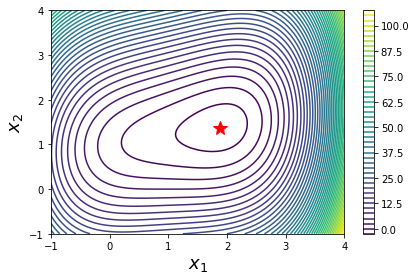

In [129]:
fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-1, 4, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, f_lmbda(X, Y), 50)
ax.plot(X_opt[0], X_opt[1], 'r*', markersize=15)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)
fig.tight_layout()
fig.savefig('ch6-examaple-two-dim.pdf');

* Not always possible to provide functions for gradients & Hessians. Sometimes better to estimate them.
* BFGS (*optimize.fmin_bfgs()*) and conjugate-gradient (*optimize.fmin_cg()*) methods help here.
* Rule of thumb: BFGS still a good starting point

### Brute force search for initial point
* Suitable when problem space has *many* local minima

In [130]:
# objective function
def f(X):
    x, y = X
    return (4*np.sin(np.pi*x) + 6*np.sin(np.pi*y)) + (x-1)**2 + (y-1)**2

In [131]:
# brute-force search:
# slice objects == coordinate grid search space
# finish=None == auto-refine best candidate

x_start = optimize.brute(f, 
                         (slice(-3, 5, 0.5), 
                          slice(-3, 5, 0.5)), 
                         finish=None)
x_start, f(x_start)

(array([ 1.5,  1.5]), -9.5)

In [132]:
# we now have good starting point for interative solver like BFGS
x_opt = optimize.fmin_bfgs(f, x_start)

Optimization terminated successfully.
         Current function value: -9.520229
         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 7


In [133]:
x_opt, f(x_opt)

(array([ 1.47586906,  1.48365787]), -9.5202292730550155)

In [134]:
# visualize solution
# need wrapper to shuffle params

def func_X_Y_to_XY(f, X, Y):
    s = np.shape(X)
    return f(
        np.vstack(
            [X.ravel(), Y.ravel()])).reshape(*s)

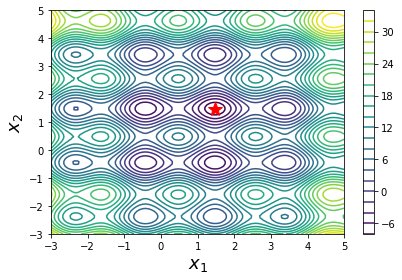

In [135]:
fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-3, 5, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 25)
ax.plot(x_opt[0], x_opt[1], 'r*', markersize=15)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)
fig.tight_layout()
fig.savefig('ch6-example-2d-many-minima.pdf');

### Nonlinear least square problems
* Most popular solver method: *Levenberg-Marquardt*

In [136]:
def f(x, beta0, beta1, beta2):
    return beta0 + beta1 * np.exp(-beta2 * x**2)

In [137]:
beta = (0.25, 0.75, 0.5)

In [138]:
# generate random datapoints
xdata = np.linspace(0, 5, 50)
y = f(xdata, *beta)
ydata = y + 0.05 * np.random.randn(len(xdata))

In [139]:
# start solver by defining function for residuals
def g(beta):
    return ydata - f(xdata, *beta)

In [140]:
# define initial guess for parameter vector
beta_start = (1, 1, 1)
# let leastsq() solve it
beta_opt, beta_cov = optimize.leastsq(g, beta_start)

In [141]:
# results
beta_opt

array([ 0.26253008,  0.77533212,  0.58785335])

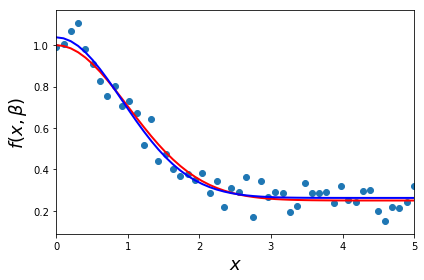

In [142]:
fig, ax = plt.subplots()

ax.scatter(xdata, ydata)
ax.plot(xdata, y, 'r', lw=2)
ax.plot(xdata, f(xdata, *beta_opt), 'b', lw=2)
ax.set_xlim(0, 5)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$f(x, \beta)$", fontsize=18)

fig.tight_layout()
fig.savefig('ch6-nonlinear-least-square.pdf')

In [143]:
# alternative method: curve_fit()
# convenience wrapper around leastsq()
# eliminates need to explicitly define residual function

beta_opt, beta_cov = optimize.curve_fit(f, xdata, ydata)
beta_opt

array([ 0.26253008,  0.77533212,  0.58785335])

## Constrained optimization

* Simple example: optimization with coordinates subject to boundary conditions
* SciPy offers *L-BFGS-B* method for this use case

In [144]:
# objective function
def f(X):
    x, y = X
    return (x-1)**2 + (y-1)**2

In [145]:
x_opt = optimize.minimize(
    f, (0, 0), 
    method='BFGS').x

In [146]:
# boundary constraints
bnd_x1, bnd_x2 = (2, 3), (0, 2)

x_cons_opt = optimize.minimize(
    f, np.array([0, 0]), 
    method='L-BFGS-B', 
    bounds=[bnd_x1, bnd_x2]).x

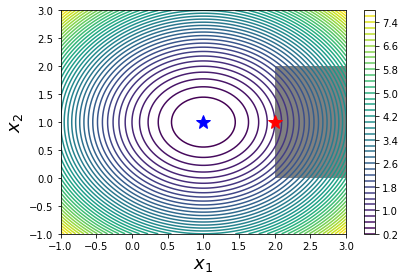

In [147]:
fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 50)
ax.plot(x_opt[0], x_opt[1], 'b*', markersize=15)
ax.plot(x_cons_opt[0], x_cons_opt[1], 'r*', markersize=15)
bound_rect = plt.Rectangle((bnd_x1[0], bnd_x2[0]), 
                           bnd_x1[1] - bnd_x1[0], bnd_x2[1] - bnd_x2[0],
                           facecolor="grey")
ax.add_patch(bound_rect)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)

fig.tight_layout()
fig.savefig('ch6-example-constraint-bound.pdf');

# unconstrained = blue star
# constrained   = red star

### Lagrange multipliers
* A technique for converting constrained optimization into unconstrained equivalent by intro'ing more variables.

In [148]:
# use case:
# maximize volume of rectangle with dimensions x1,x2,x3
# constraint: total surface area must be unity (1.0)

# symbolics first
x = x1, x2, x3, l = sympy.symbols("x_1, x_2, x_3, lambda")

In [149]:
# volume
f = x1*x2*x3

In [150]:
# surface area constraint
g = 2 * (x1*x2 + x2*x3 + x3*x1) - 1

In [151]:
# Lagrangian
L      = f + l*g

In [152]:
# Lagrangian gradient
grad_L = [sympy.diff(L, x_) 
          for x_ in x]

# solve for zero. should return two points.
# However, 2nd point has x1<0 = not viable use case. (x1 is a dimension)
# so 1st point must be answer.
sols = sympy.solve(grad_L)
sols

In [153]:
# verify by eval'ing constraint func & objective func using answer
g.subs(sols[0]), f.subs(sols[0])

* Can be used to handle inequality constraints too.
* SciPy offers *optimize.slsqp()* (sequential least squares programming)

In [154]:
# objective function
def f(X):
    return -X[0] * X[1] * X[2]
# constraint function
def g(X):
    return 2 * (X[0]*X[1] + X[1] * X[2] + X[2] * X[0]) - 1

In [155]:
constraints = [dict(type='eq', fun=g)] # type = 'eq'

In [156]:
result = optimize.minimize(
    f, [0.5, 1, 1.5], 
    method='SLSQP', 
    constraints=constraints)
result

     fun: -0.068041368622872966
     jac: array([-0.16666925, -0.16666542, -0.16666526,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([ 0.40824188,  0.40825127,  0.40825165])

In [157]:
result.x

array([ 0.40824188,  0.40825127,  0.40825165])

### Inequality constraints

In [158]:
# objective function
def f(X):
    return (X[0] - 1)**2 + (X[1] - 1)**2
# constraint function
def g(X):
    return X[1] - 1.75 - (X[0] - 0.75)**4

In [159]:
x_opt = optimize.minimize(
    f, (0, 0), method='BFGS').x

In [160]:
constraints = [dict(type='ineq', fun=g)] # type = 'ineq'

In [161]:
x_cons_opt = optimize.minimize(
    f, (0, 0), 
    method='SLSQP', 
    constraints=constraints).x

In [162]:
# alternative solver:
# constrained optimization by linear approximation (COBYLA)

x_cons_opt = optimize.minimize(
    f, (0, 0), 
    method='COBYLA', 
    constraints=constraints).x

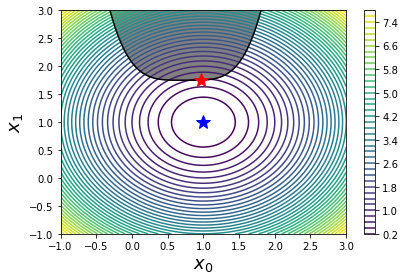

In [163]:
fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 50)
ax.plot(x_opt[0], x_opt[1], 'b*', markersize=15)

ax.plot(x_, 1.75 + (x_-0.75)**4, 'k-', markersize=15)
ax.fill_between(x_, 1.75 + (x_-0.75)**4, 3, color="grey")
ax.plot(x_cons_opt[0], x_cons_opt[1], 'r*', markersize=15)

ax.set_ylim(-1, 3)
ax.set_xlabel(r"$x_0$", fontsize=18)
ax.set_ylabel(r"$x_1$", fontsize=18)
plt.colorbar(c, ax=ax)

fig.tight_layout()
fig.savefig('ch6-example-constraint-inequality.pdf');

### Linear programming

In [164]:
c = np.array([-1.0, 2.0, -3.0])

A = np.array([[ 1.0, 1.0, 0.0],
              [-1.0, 3.0, 0.0],
              [ 0.0, -1.0, 1.0]])

b = np.array([1.0, 2.0, 3.0])

In [165]:
# using cvxopt library
# has unique classes for matrices & vectors - can talk to NumPy
A_ = cvxopt.matrix(A)
b_ = cvxopt.matrix(b)
c_ = cvxopt.matrix(c)

In [166]:
sol = cvxopt.solvers.lp(c_, A_, b_)
sol

Optimal solution found.


{'dual infeasibility': 2.967195843610875e-17,
 'dual objective': -10.0,
 'dual slack': 2.7755575615628914e-17,
 'gap': 0.0,
 'iterations': 0,
 'primal infeasibility': 0.0,
 'primal objective': -10.0,
 'primal slack': -0.0,
 'relative gap': 0.0,
 'residual as dual infeasibility certificate': None,
 'residual as primal infeasibility certificate': None,
 's': <3x1 matrix, tc='d'>,
 'status': 'optimal',
 'x': <3x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 'z': <3x1 matrix, tc='d'>}

In [167]:
x = np.array(sol['x'])
x

array([[ 0.25],
       [ 0.75],
       [ 3.75]])

In [168]:
sol['primal objective']